### IMPORT LIBRARIES

In [6]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt

In [7]:
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_squared_error 

In [8]:
import composition
import utils

In [40]:
df = pd.read_csv("/Users/umakantmanore/Desktop/amu/Dev_Enviroment2023/test_env/Material_Properties/materials.csv")
df = df.rename(columns={'AEL VRH bulk modulus ': 'Bulk modulus', 'AEL elastic anisotropy ': 'Elastic anisotropy',
                        'AEL Poisson ratio ': 'Poisson ratio', 'AEL VRH shear modulus ': 'Shear modulus', 
                        'Pearson symbol ': 'Pearson symbol'})

df.head()
df.columns

Index(['ENTRY ', 'Bulk modulus', 'Elastic anisotropy', 'Poisson ratio',
       'Shear modulus', 'space group ', 'Pearson symbol', 'DATA'],
      dtype='object')

In [41]:
df.shape

(2382, 8)

### CLEAN THE DATA

In [10]:
uncleaned_formulae = df['ENTRY ']

In [11]:
cleaned_formulae = []


cell_value format: "Ag10S8Sb2 [e6cass8dks00as]"

desired format: "Ag10S8Sb2"

need to remove: " [e6cass8dks00as]"

We want to read the cell value and only extract the formula.
We can do this by removing all characters that come after the " ["
To accomplish this, I will use the code: value.split("[")
part of the split. (str.split() returns a list, we want the index "0")

In [12]:
for value in uncleaned_formulae:
    #split string into list
    split_list = value.split(" [")
    clean_formula = split_list[0]
    cleaned_formulae.append(clean_formula)

In [13]:
#Lets now create a new dataframe to hold the clean data 
df_cleaned = pd.DataFrame()

#adding columns to the DF
df_cleaned['formula'] = cleaned_formulae

#adding a column with the target property we want to predict
#Here I am targeting to predict bulk modulus of the material
df_cleaned['bulk_modulus'] = df['Bulk modulus']

### EVALUATE THE DATA

#### Handle duplicate formula instances
As a first step, we can check for duplicates. Because this data is ordered in
a well though manner, we can get away looking for matching strings.
For chemical formula, it is probably better to check for duplicates on a 
chemical basis (ie. do the fractional compositions match, Al2O3 = Al4O6)

We can use "series.value_counts()" on the formula column to see if a string
value appears more than once.

In [14]:
check_for_duplicates = df_cleaned['formula'].value_counts()
check_for_duplicates

Cu2Sb2Yb2    2
Au2Sn2Tb2    2
Ca2Sn2Zn2    2
Hf4O12Sr4    2
Dy2Pd2Sb2    2
            ..
Ca1Pt1Si3    1
Ca1Rh2Si2    1
Ca1Si2Zn2    1
Ca2Cu2F8     1
Sn6V6Y1      1
Name: formula, Length: 2336, dtype: int64

There are duplicates in the data. We can just drop duplicates after first instance

In [15]:
df_cleaned.drop_duplicates('formula', keep='first', inplace=True)

#### CHECK THE PROPERTY FOR ANYTHING ODD
We can now look at the property to see if there is anything unexpected.
Some things we might want to look out for: "should there be negative values?"
"How high does this property get?" "What do I expect the average to be?" etc.

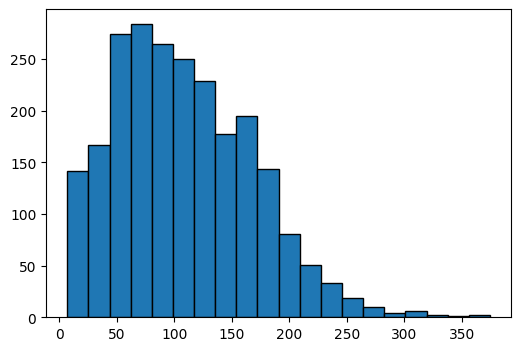

In [16]:
plt.figure(figsize=(6,4))
df_cleaned['bulk_modulus'].hist(bins=20, grid=False, edgecolor = 'black')
plt.show()

### FEATURIZE THE DATA
We can now look at making the chemical formula "machine readable".
We want to be able to give the compute a vector that describes the formula
in a meaninful way. 

The simplest version of this is a vector were each component represents a
different formula, ie. (Ag, Al, ..., O, ..., Zr). Each formula (take alumina)
can now be easily encoded.  Al2O3 ==> (0, 2, ..., 3, ..., 0)
We can usually do better however. Instead of using just the elements, we can
make a feature from a combination of atomic & elemental properties
to make a composition-based feature vector (CBFV).

I have supplied code (composition.py) that does this for us automatically. 
If we a pandas.DataFrame with a 'formula' and 'target' column, the function 
will return the features for each instance of data (X), the target values (y)
and the formula associated with those (formulae).

In [17]:
#Rename columns to match the required input
df_cleaned.columns = ['formula', 'target']

#Lets convert our chemical formula into features
X, y, formulae = composition.generate_features(df_cleaned)

The element: Pu from formula C8Pu4W4 is not currently supported in our database


### TRAIN TEST SPLIT
Now that we have a "machine_readable" input, we want to partition our data
into a train and test split. The training set will be used to train and 
optimize our model. The test set will be reserved till the end to ensure our
model is capable of accurate predictions beyond the data used for training.

lets perform this step using sklearn function "train_test_split". 
We simple give it the fraction of data we want in the test set. We can also
give it a 'random seed' so we can recreate the same split everytime.

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### SCALING THE DATA

We can use StandardScalar to scale each feature to a mean=0 and variance=1.
We then normalize the vector for each instance of data. This is done for
numerical purposes (allows us to use gradient-descent-based algorithms).

FOR STANDARD SCALAR:
"Fit the training data" (calculate the mean & variance of the training data)
"Transform" (subtract mean & divide by variance from each instance of data)

FOR NORMALIZER:
"Fit" (does nothing, but is kept for workflow purposes)
"Transform" (scales the vector, for each instance of data, to unit norm)

In [19]:
scalar = StandardScaler()
normalizer = Normalizer()

In [20]:
# Do the scaling step
X_train_scaled = scalar.fit_transform(X_train)  # get statistics & transform
X_test_scaled = scalar.transform(X_test)  # transform using 'training' stats.
# Do the normalizing step
X_train_scaled = normalizer.fit_transform(X_train_scaled)  # normalize vectors
X_test_scaled = normalizer.transform(X_test_scaled)  # normalize vectors

Algorithms that generally need scaling: Linear, Ridge, & Lasso regressions,
Support Vector Machines, Neural Networks, Logistic regression

Algorithms that DO NOT need scaling: Decision Tree, Random Forest,
Gradient Tree Boosting, etc. (usually decision tree based algorithms)


### DESIRED ALGORITHM
We can consult the literature and see that most non-linear algorithm do a
good job of predicting materials properties from the composition. Let's
follow the Brgoch group and use a support vector regression. 

here we can define the algorithm we want to use to model the data

In [21]:
model = SVR()

### OPTIMIZE PARAMETERS
We are using a SVR to model the data. We can change the parameters we use in
the modeling to get better or worse models. These parameters generally
dictate the amount of 'regularization' we apply to the model. Regularization 
is our metaphorical dial for adjusting model complexity. Using a small amount
of regularization may lead to a model that is too complex, grossly overfiting
on the training data. Using too much regularization makes our model "simple"
incapable of learning anything useful. We want to balance this by searching
over a large range of possible parameter values. For simplicity we will use 
a grid search.

We first start by defining a cross-validation scheme. In this case we can use
5-fold cross-validation on shuffled data.

In [22]:
cv = KFold(n_splits=5, shuffle=True, random_state=1)

We now define the parameter space we want to search over. I have
found C=100 and gamma=1 to be generally effective values. Center our parameter
search around these values. Note, it is good practice to have your search
span several orders of magnitude. We will set our parameters accordingly.

In [23]:
c_parameters = np.logspace(-1, 3, 5)
gamma_parameters = np.logspace(-2, 2, 5)

In [24]:
#save the search space as a dictionary
parameter_candidates = {'C': c_parameters, 'gamma': gamma_parameters}

In [25]:
#with this line, we will define the full grid search
grid = GridSearchCV(estimator=model, param_grid=parameter_candidates, cv=cv)

In [26]:
#here we start running the grid search
# the grid object will contain the optimal parameters when our search is done
grid.fit(X_train_scaled, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=1, shuffle=True),
             estimator=SVR(),
             param_grid={'C': array([1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'gamma': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])})

In [27]:
#here we save the best parameters
best_parameters = grid.best_params_ 
print(best_parameters)

{'C': 100.0, 'gamma': 1.0}


[]

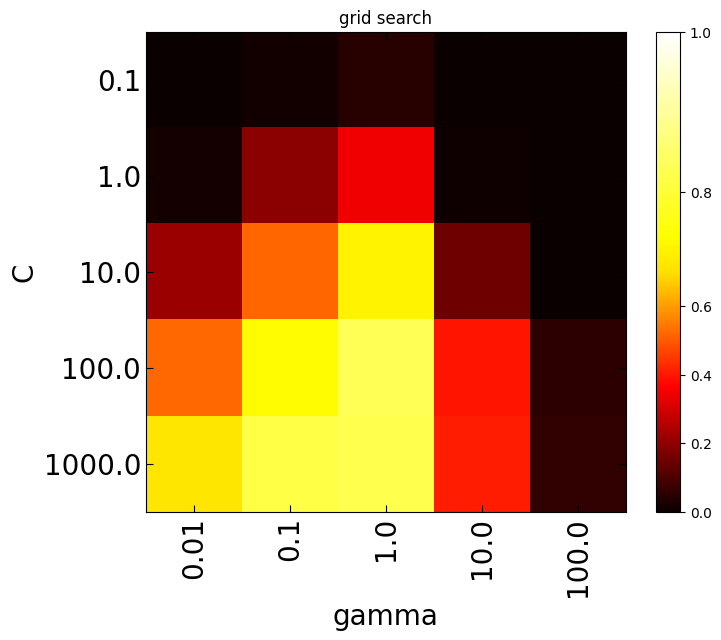

In [28]:
#here we visualize model performance for different model parameters
utils.plot_2d_grid_search(grid, midpoint=0.7, vmin=-0, vmax=1)
plt.plot()

### PERFORMANCE ANALYSIS
We can now use these optimal parameters to fit a model to all the training
data. This model can then be applied to the test data to see how well we did.

make our final model using the "best_parameters" dictionary as our arguments.

In [29]:
final_model = SVR(**best_parameters)

In [30]:
#fit the model to the training data
final_model.fit(X_train_scaled, y_train)

SVR(C=100.0, gamma=1.0)

In [31]:
y_test_predicted = final_model.predict(X_test_scaled)

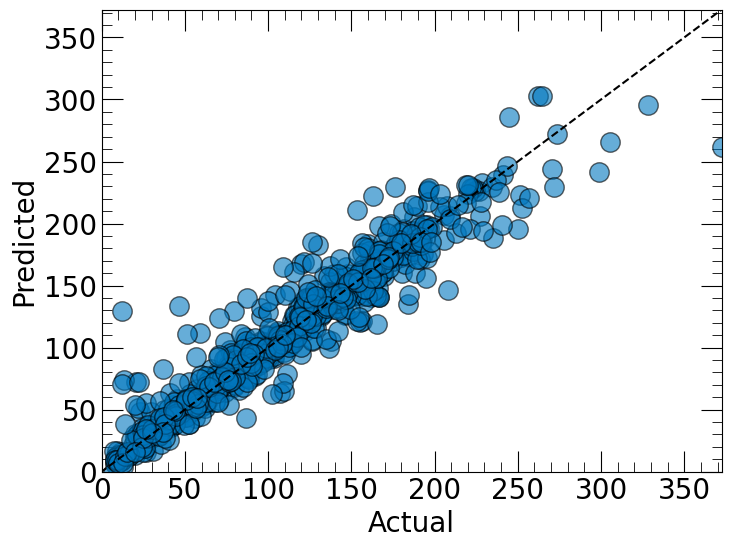

In [32]:
#plot the results to see how we did
utils.plot_act_vs_pred(y_test, y_test_predicted)
score = r2_score(y_test, y_test_predicted)
rmse = np.sqrt(mean_squared_error(y_test, y_test_predicted))

In [33]:
print(f'r2 score : {score}, rmse: {rmse}')

r2 score : 0.9192273196775613, rmse: 17.08609662962355


### PREDICTIONS

If we want to make predictions for a new compounds, we will first need to
vectorize the composition. We will then need to scale it by the training data
and finally, we will need to make predictions from the trained model. 

Lets define a simple class to do that here

In [34]:
class MaterialsModel():
    def __init__(self, trained_model, scalar, normalizer):
        self.model = trained_model
        self.scalar = scalar
        self.normalizer = normalizer

    def predict(self, formula):
        '''
        Parameters
        ----------
        formula: str or list of strings
            input chemical formula or list of formulae you want predictions for
    
        Return
        ----------
        prediction: pd.DataFrame()
            predicted values generated from the given data
        '''
        # Store our formula in a dataframe. Give dummy 'target value'.
        # (I will use composition.generate_features() to get the features)
        df_formula = pd.DataFrame()
        if type(formula) is str:
            df_formula['formula'] = [formula]
            df_formula['target'] = [0]
        elif type(formula) is list:
            df_formula['formula'] = formula 
            df_formula['target'] = np.zeros(len(formula))
        else:
            raise ValueError("Input must be a string or a list of strings.")
        #here we get the features associated with the formula
        X, y, formula_series = composition.generate_features(df_formula)

        #here we scale the data (according to the training set statistics)
        X_scaled = self.scalar.transform(X)
        X_scaled = self.normalizer.transform(X_scaled)
        y_predicted = self.model.predict(X_scaled)
        #save our predictions to a dataframe
        prediction = pd.DataFrame(formula_series)
        prediction['predicted value'] = y_predicted
        return prediction


In [35]:
    
#initialize an object to hold our bulk modulus model
bulk_modulus_model = MaterialsModel(final_model, scalar, normalizer)

In [36]:
#lets define some formulae we are interested in 
formulae_to_predict = ['NaCl', 'Cu2O4', 'NaNO3', 'H2O', 'NaOH']

#use the bulk modulus object to generate predictions for our formulae
bulk_modulus_prediction = bulk_modulus_model.predict(formulae_to_predict)
print(bulk_modulus_prediction)

  formula  predicted value
0    NaCl        43.982859
1   Cu2O4       116.709586
2   NaNO3        85.893870
3     H2O       102.292803
4    NaOH        70.710416


In [37]:
formula = ['NaCl']
print(bulk_modulus_model.predict(formula))

  formula  predicted value
0    NaCl        43.820319


SVR - R2 score: 0.9192273196775613
Linear Regression - R2 score: 0.8788870770054963
Random Forest - R2 score: 0.9022839046634243
Gradient Boosting - R2 score: 0.9010889578009791


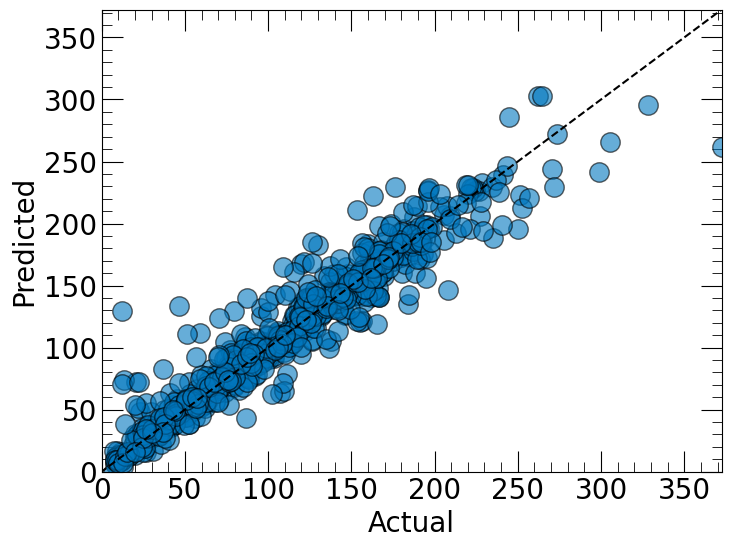

In [38]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

models = {
    'SVR': SVR(),
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(),
    'Gradient Boosting': GradientBoostingRegressor()
}

# Step 4: Hyperparameter Tuning Setup
param_grids = {
    'SVR': {'C': np.logspace(-1, 3, 5), 'gamma': np.logspace(-2, 2, 5)},
    'Random Forest': {'n_estimators': [100, 200], 'max_depth': [None, 10, 20]},
    'Gradient Boosting': {'learning_rate': [0.01, 0.1, 0.5], 'n_estimators': [100, 200]}
}

# Step 5: Cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=1)

# Step 6: Evaluate Models
best_model = None
best_score = -np.inf
for model_name, model in models.items():
    grid = GridSearchCV(estimator=model, param_grid=param_grids.get(model_name, {}), cv=cv)
    grid.fit(X_train_scaled, y_train)
    y_test_pred = grid.predict(X_test_scaled)
    score = r2_score(y_test, y_test_pred)
    print(f"{model_name} - R2 score: {score}")
    
    if score > best_score:
        best_score = score
        best_model = grid.best_estimator_

# Step 7: Visualize Results
utils.plot_act_vs_pred(y_test, best_model.predict(X_test_scaled))
plt.show()
